In [92]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

In [63]:
def hamiltonian(spins, h, J):


    spins = jnp.asarray(s)
    h = jnp.asarray(h)
    J = jnp.asarray(J)

    
    return - jnp.dot(h, spins) - 0.5 * spins @ (J @ spins)


In [64]:
def local_field(spins, h, J):


    return jnp.asarray(h) + J @ jnp.asarray(spins)

In [65]:
def glauber_step(spins, key, h, J_off, beta):


    d = spins.shape[0]

    key_idx, key_u, key_new = jax.random.split(key, 3)

    site = jax.random.randint(key_idx, (), 0, d)

    local_fields = local_field(spins, h, J_off)

    p_plus = jax.nn.sigmoid(2.0 * beta * local_fields[site])

    u = jax.random.uniform(key_u)
    new_spin_value = jnp.where(u < p_plus, 1, -1)

    spins_new = spins.at[site].set(new_spin_value)


    return spins_new, key_new

In [66]:
def glauber_steps(spins, key, h, J, beta, n_steps):


    for i in range(int(n_steps)):
        spins, key = glauber_step(spins, key, h, J, beta)


    return spins

In [ ]:
def glauber_steps_and_self(spins, key, h, J_off, beta, n_steps, burn_in, log_stride=200):


    d = spins.shape[0]
    sum_s = jnp.zeros(d)
    sum_tanh = jnp.zeros(d)
    cnt = 0

    counts = []
    gaps   = []

    for t in range(int(n_steps)):
        spins, key = glauber_step(spins, key, h, J_off, beta)

        if t >= burn_in:
            ell = h + J_off @ spins
            sum_s    = sum_s    + spins
            sum_tanh = sum_tanh + jnp.tanh(beta * ell)
            cnt += 1

            if (cnt % log_stride) == 0:
                lhs = sum_s / cnt
                rhs = sum_tanh / cnt
                err = jnp.mean(jnp.abs(lhs - rhs))
                counts.append(cnt)
                gaps.append(float(err))

    if cnt > 0:
        lhs_final = sum_s / cnt
        rhs_final = sum_tanh / cnt
    else:
        lhs_final = jnp.zeros(d)
        rhs_final = jnp.zeros(d)

    return spins, key, jnp.array(counts), jnp.array(gaps), lhs_final, rhs_final

In [85]:
def plot_self_consistency_gap(counts, gaps, title="Self-consistency gap vs samples",
                              ymin=None, ymax=None):

    counts = np.asarray(counts)
    gaps   = np.asarray(gaps)

    plt.figure()
    plt.plot(counts, gaps)
    plt.xlabel("Post-burn-in samples used")
    plt.ylabel(r"Mean absolute gap  $|\mathbb{E}[s] - \mathbb{E}[\tanh(\beta \ell)]|$")
    plt.title(title)

    if ymin is not None or ymax is not None:
        if ymin is None: ymin = float(np.nanmin(gaps))
        if ymax is None: ymax = float(np.nanmax(gaps))
        plt.ylim(ymin, ymax)

    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

In [86]:
key = jax.random.key(0)

d = 8
h = jnp.array([0.0, 0.1, -0.2, 0.3, 0.0, -0.2, 0.3, 0.0])

J = jnp.array([
    [ 0.0,  0.0, -0.1,  0.0,  0.0,  0.0,  0.0, -0.2],
    [ 0.0,  0.0,  0.3,  0.1,  0.0,  0.0, -0.4,  0.0],
    [-0.1,  0.3,  0.0, -0.2,  0.4,  0.0,  0.1,  0.0],
    [ 0.0,  0.1, -0.2,  0.0,  0.5, -0.3,  0.0,  0.2],
    [ 0.0,  0.0,  0.4,  0.5,  0.0,  0.2, -0.1,  0.0],
    [ 0.0,  0.0,  0.0, -0.3,  0.2,  0.0,  0.3,  0.4],
    [ 0.0, -0.4,  0.1,  0.0, -0.1,  0.3,  0.0,  0.2],
    [-0.2,  0.0,  0.0,  0.2,  0.0,  0.4,  0.2,  0.0],
])


spins0 = jnp.array([1, -1, 1, 1, -1, 1, 1, 1])

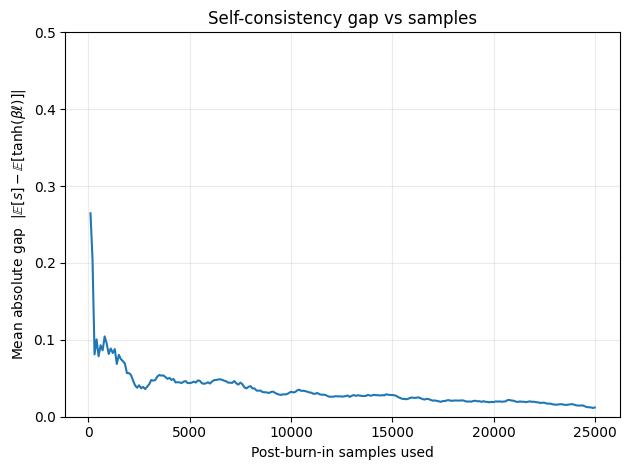

In [ ]:
spins, key, counts, gaps, lhs_fin, rhs_fin = glauber_steps_and_self(
    spins0, key, h, J, beta=0.6,
    n_steps=30_000, burn_in=5_000, log_stride=100
)
plot_self_consistency_gap(counts, gaps, ymin=0.0, ymax=0.5)

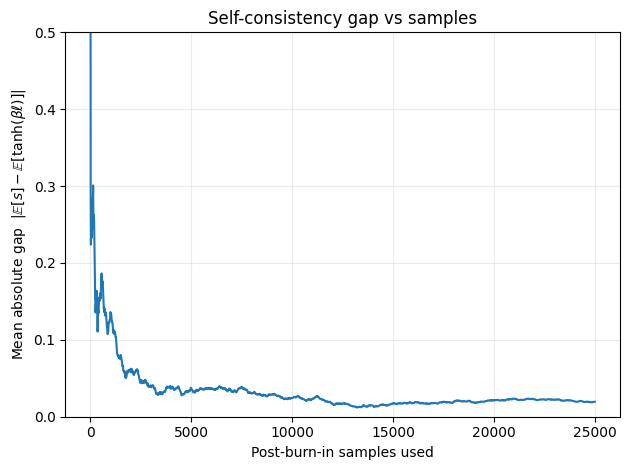

In [ ]:
spins, key, counts, gaps, lhs_fin, rhs_fin = glauber_steps_and_self(
    spins0, key, h, J, beta=0.6,
    n_steps=30_000, burn_in=5_000, log_stride=10
)
plot_self_consistency_gap(counts, gaps, ymin=0.0, ymax=0.5)

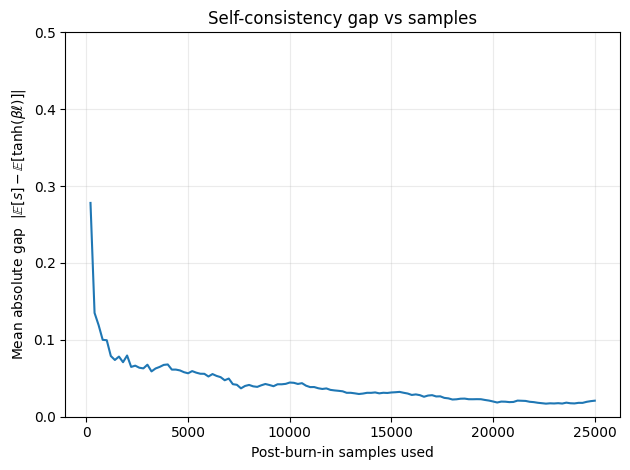

In [ ]:
spins, key, counts, gaps, lhs_fin, rhs_fin = glauber_steps_and_self(
    spins0, key, h, J, beta=0.6,
    n_steps=30_000, burn_in=5_000, log_stride=200
)
plot_self_consistency_gap(counts, gaps, ymin=0.0, ymax=0.5)